In [1]:
import numpy as np
import pandas as pd
import torch as torch
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [43]:
## función para graficar
def graficar(X, Y1, Y2, xlabel, ylabel):
    
    if Y2:
        _, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

        ax1.plot(X, Y1)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax2.set_xlabel(xlabel)
        ax2.plot(X, Y2)
    else:
        plt.plot(X, Y1)
        plt.xlabel(xlabel)        
        plt.ylabel(ylabel)

    plt.suptitle("Error datos de entrenamiento y datos de prueba")
    plt.tight_layout(pad=3.0)

    plt.show()

In [11]:
## reemplazos textuales para curar los datos del dataset
replacements = [
["\"This Listing Is For Verified", "This Listing Is For Verified", -1],
["\"This subtropical", "This subtropical", -1],
["\"This po", "This po", -1],
["\"Mr. H", "Mr. H", -1],
["\"An engaging", "An engaging", -1],
[",\"Professional F", ",Professional F", -1],
[",\"Professional D", ",Professional D", -1],
["SKU:90183\"", "SKU:90183", -1],
["\"Encryption", "Encryption", -1],
["\"ProSoma", "ProSoma", -1],
["\"If you’", "If you’", -1],
[",\"Named", "Named", -1],
[",\"THC", ",THC", -1],
["\"Strassman'", "Strassman'", -1],
["\"You d", "You d", -1],
[",\"This is your", ",This is your", -1],
["35,\"P", "35,P", -1],
["wing,\"", "wing,", -1],
["22,\"I", "22,I", -1],
[",\"G13", ",G13", -1],
["0,\"Pl", "0,Pl", -1],
["s Sunglasses Replica are 1:1  ...", "s Sunglasses Replica are 1:1 ...\"", -1],
["],,,,", "],", -1],
[",David Icke (", ",\"David Icke (", -1],
["r Bud,I", "r Bud,\"I", -1],
["hone,B", "hone,\"B", -1],
["h,I r", "h,\"I r", -1],
[".,0.01547", ".\",0.01547", -1],
["~5/5,,", "~5/5,", -1],
[".,2.32555", ".\",2.32555", -1],
["/5,,", "/5,", -1],
[".,0.130088", ".\",0.130088", -1],
["tazepam,", "tazepam\",", -1],
["E,15.8", "E\",15.8", -1],
["Quality\"\" we've all come to know and love. This MD ...\",1", 
                        "Quality we've all come to know and love. This MD ...,1", -1] ]

with open("Agora2.csv", "wb") as nuevoArchivo: # trunca el archivo si ya existe
    with open("Agora.csv", mode="r", encoding="UTF-8", errors="ignore") as archivoOriginal:
        numero = 1
        for linea in archivoOriginal:
            if numero == 5000:
                break
            try:
                # se corrigen los errores encontrados
                for rep in replacements:
                    modified = False
                    if rep[0] in linea:
                        if not modified:
                            rep[2] = numero
                            modified = True
                        linea = linea.replace(rep[0], rep[1])
                
                # se almacena el texto en el nuevo archivo
                linea = linea.encode("utf-8")
                nuevoArchivo.write(linea)
            except Exception as e:
                print("Error con el string", numero, linea, e)
                raise e
            finally:
                numero += 1

# replacements

In [12]:
df = pd.read_csv("Agora2.csv")
df.describe()

,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
count,4998,4998,4998,4998,4998,3521,1525,4998,721
unique,339,21,4953,3930,4870,61,84,74,1
top,fake,Drugs/Prescription,The Great Big Narcotics Cookbook,This shipment is with tracking number. The shi...,0.00415549 BTC,USA,Worldwide,5.00/5,Average price may be skewed outliar > .5 BTC f...
freq,467,1057,3,96,29,691,492,839,721


In [13]:
print('Cantidad de filas iniciales:', df.shape[0])

# queda en 10737 si outliers
df = df[df[" Remarks"] != "Average price may be skewed outliar > .5 BTC found"]
print('Cantidad de filas sin outliars:', df.shape[0])

# Elimina entradas sin rating
df.dropna(subset = [" Rating"], inplace=True)
print('Cantidad de filas con rating no nulo:', df.shape[0])

# se deja los Ratings válidos - que terminan en '/5'
df = df[df[" Rating"].str.endswith("/5")]
print('Cantidad de filas con ratings válidos:', df.shape[0])

# Todas las entradas tienen precio, entonces **no elimina** ninguna fila
df.dropna(subset = [" Price"], inplace=True)
print('Cantidad de filas con precio:', df.shape[0])

# Verifica la cantidad de entradas que terminan con 'BTC'
print('cantidad de precios en BTC:', df[" Price"].str.endswith('BTC').count() )

# texto a números
df[" Price"]  = df[" Price"].str.replace(" BTC" , "")
df[" Rating"] = df[" Rating"].str.replace("/5" , "")
df[" Rating"] = df[" Rating"].str.replace("~" , "")
df[" Price"]  = pd.to_numeric(df[" Price"], errors ="coerce")
df[" Rating"] = pd.to_numeric(df[" Rating"], errors ="coerce")



# eliminar features no necesarios
df.drop(columns=[" Item", " Item Description", " Origin", " Destination", " Remarks"], inplace=True)
print('Columnas restantes:', df.columns)

df.describe()

Cantidad de filas iniciales: 4998
Cantidad de filas sin outliars: 4277
Cantidad de filas con rating no nulo: 4277
Cantidad de filas con ratings válidos: 4088
Cantidad de filas con precio: 4088
cantidad de precios en BTC: 4088
Columnas restantes: Index(['Vendor', ' Category', ' Price', ' Rating'], dtype='object')


,Price,Rating
count,4.088000e+03,4088.000000
mean,6.705033e+00,4.866215
std,3.511620e+02,0.337424
min,1.000000e-07,0.000000
25%,2.818479e-02,4.827750
50%,1.000080e-01,4.960000
75%,2.541704e-01,4.994000
max,2.198500e+04,5.000000


In [14]:
def soloCategoria(cat):
    posInicio = cat.find("/")
    if posInicio == -1:
        return cat
    
    posFin = cat.rindex("/")
    if posInicio == posFin:
        return cat[posInicio+1:]
    return cat[posInicio+1:posFin]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(soloCategoria)

# codifica la categoría usando one-hot-encoding
oneHotEncoded = pd.get_dummies(df, columns=[" Category"], prefix="Cat")


## Retorna la categoría correspondiente al rating.
## El valor Rating de los datos está en el rango [2.6, 5.0]
## Categorías resultantes:
## - 2: bueno
## - 1: regular
## - 0: malo
def categoriasDeRating(valor):
    if valor > 4.1:
        return 2 # bueno
    if valor > 3.2:
        return 1 # regular
    return 0 #malo

df[" RatingClass"] = df[ " Rating" ].apply(categoriasDeRating)

In [15]:
print(df[" Rating"])
oneHotEncoded.drop(columns=["Vendor", " Rating"], inplace=True)
print("Datos codificados usando one-hot-encoding", oneHotEncoded.shape[0])
print("Total columnas: ", oneHotEncoded.shape[1], oneHotEncoded.columns)

0       4.96
1       4.96
2       4.93
3       4.89
4       4.88
        ... 
4993    4.96
4994    4.67
4995    4.96
4996    4.96
4997    4.96
Name:  Rating, Length: 4088, dtype: float64
Datos codificados usando one-hot-encoding 4088
Total columnas:  20 Index([' Price', 'Cat_Accounts', 'Cat_Clothing', 'Cat_Electronics',
       'Cat_Guides', 'Cat_Hacking', 'Cat_Jewelry', 'Cat_Money', 'Cat_Other',
       'Cat_Physical documents', 'Cat_Pipes', 'Cat_Pirated',
       'Cat_Prescription', 'Cat_RCs', 'Cat_Scans', 'Cat_Smoked',
       'Cat_Software', 'Cat_Steroids', 'Cat_Weight loss', 'Cat_eBooks'],
      dtype='object')


In [16]:
## datos para usar regresión
X_train, X_test, Y_train, Y_test = train_test_split(oneHotEncoded, df[" Rating"], random_state=13)
print("Cantidad de valores para entrenar:", Y_train.shape[0])
print("Cantidad de valores para comprobar:", Y_test.shape[0])

Cantidad de valores para entrenar: 3066
Cantidad de valores para comprobar: 1022


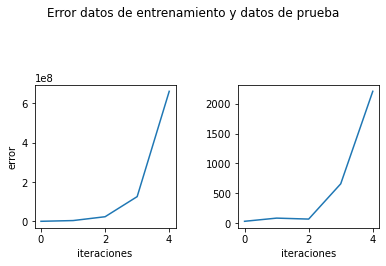

In [45]:
# regresión lineal usando pytorch

## modelo lineal
def modeloLineal(x, w, b):
    return x @ w + b

## función de cálculo de error, usando mse
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()


## Calcula un epoch más para la regresión lineal
def regresionLinealForward(metrica, inputs, targets, w, b):
    preds = modeloLineal(inputs, w, b)
    loss = metrica(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()
        error = loss.numpy()
    return error

## Va entrenando la regresión lineal y calculando la tasa de error
## de los datos para pruebas
def testRegresionLineal():
    # convierte a tensor de pytorch
    inputs = torch.tensor(X_train.values)
    target = torch.tensor(Y_train.values)
    
    inputs_test = torch.tensor(X_test.values)
    target_test = torch.tensor(Y_test.values)
    
    # valores iniciales, aleatorios
    torch.manual_seed(0)
    w = torch.randn(inputs.shape[1], 1, dtype=torch.float64, requires_grad=True)
    b = torch.randn(1, dtype=torch.float64, requires_grad=True)
    
    # epochs
    iteraciones = range(5)
    erroresEntrenamiento = []
    erroresPruebas = []
    for i in iteraciones:
        # un paso de entrenamiento
        errorEntrenamiento = regresionLinealForward(mse, inputs, target, w, b)
        erroresEntrenamiento.append(errorEntrenamiento)
        
        # test con el modelo resultante
        predicciones = modeloLineal(inputs_test, w, b)
        errorTest = mse(predicciones, target_test)
        with torch.no_grad():
            erroresPruebas.append(errorTest.numpy())
        
    #print(erroresEntrenamiento)
    #print(erroresPruebas)
    graficar(iteraciones, erroresEntrenamiento, erroresPruebas, "iteraciones", "error")
    
testRegresionLineal()

In [30]:
## datos para usar clasificación
X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(oneHotEncoded, df[" RatingClass"], random_state=13)

[0.987279843444227, 0.987279843444227, 0.9863013698630136, 0.9853228962818004]


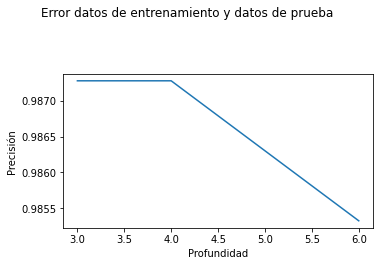

In [44]:
## Utilizando árboles de decisión

def testDecisionTree():
    profundidades = range(3, 7)
    errores = []
    for i in profundidades:
        DecisionTreeModel = DecisionTreeClassifier(max_depth = i)
        DecisionTreeModel.fit(X_class_train, Y_class_train)
        y_predict = DecisionTreeModel.predict(X_class_test)
        dt3 = accuracy_score(Y_class_test, y_predict)
        errores.append(dt3)
    
    print(errores)
    graficar(profundidades, errores, None, "Profundidad", "Precisión")

testDecisionTree()

In [33]:
range(2,3)

range(2, 3)

In [8]:
df=df[df[" Price"] <= 5]

df.fillna(df[" Price"].median(), inplace = True)
df.fillna(df[" Rating"].median(), inplace = True)
df = df.round({" Rating": 2, " Price": 4})

In [9]:
val = {}
ind_val = 1
for cate in df[" Category"].unique():
    if cate not in val:
        val.update({cate: ind_val})
        ind_val += 1

def cateToNum(cat):
    if cat in val:
        return val[cat]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(cateToNum)

# codifica la categoría
print(val)

{'Hacking': 1, 'Other': 2, 'RCs': 3, 'Physical documents': 4, 'Smoked': 5, 'Money': 6, 'Software': 7, 'Accounts': 8, 'Clothing': 9, 'eBooks': 10, 'Electronics': 11, 'Pipes': 12, 'Weight loss': 13, 'Pirated': 14, 'Steroids': 15, 'Prescription': 16, 'Guides': 17, 'Scans': 18, 'Jewelry': 19, 'Accessories': 20, 'Watches': 21, 'Cannabis': 22, 'Benzos': 23, 'Cannabis/Shake': 24, 'Dissociatives': 25, 'Ecstasy': 26}


In [10]:
val3 = {}
ind_val3 = 1
for cate in df["Vendor"].unique():
    if cate not in val:
        val3.update({cate: ind_val3})
        ind_val3 += 1

def vendorToNum(cat):
    if cat in val3:
        return val3[cat]

# usa la subcategoría
df["Vendor"] = df[ "Vendor" ].apply(vendorToNum)

In [11]:
# val2 = {}
# ind_val2 = 1
# for cate in df[" Item"].unique():
#     if cate not in val:
#         val2.update({cate: ind_val2})
#         ind_val2 += 1

# def itemToNum(cat):
#     if cat in val2:
#         return val2[cat]

# # usa la subcategoría
# df[" Item"] = df[ " Item" ].apply(itemToNum)

<AxesSubplot:>

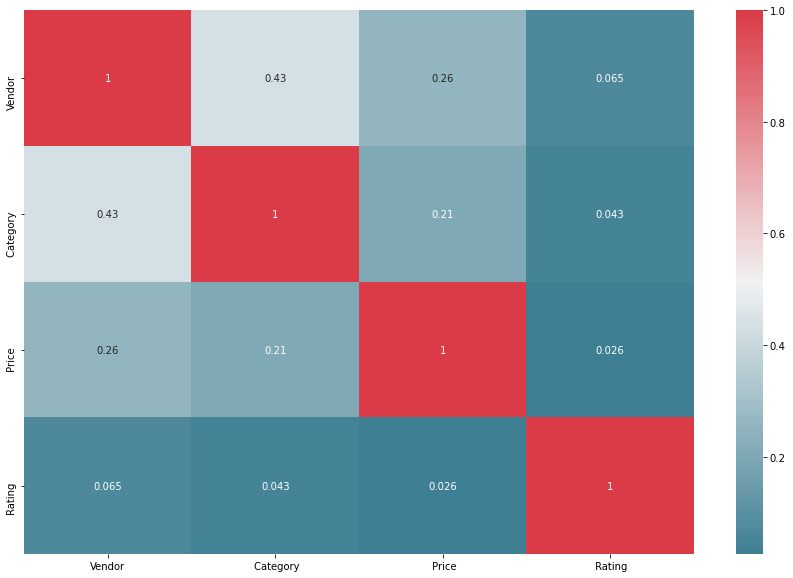

In [13]:
_,ax=plt.subplots(figsize=(15,10))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(df.corr(),annot=True,cmap=colormap)